https://www.kaggle.com/code/adaramit/customer-churn-working-with-imbalanced-dataset


In [1]:
from sklearn.model_selection import (
    train_test_split,
    RepeatedStratifiedKFold,
    cross_validate,
)
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, BorderlineSMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, f1_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score
from imblearn.datasets import fetch_datasets
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier
from numpy import mean
from collections import Counter
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from imblearn.datasets import make_imbalance
from collections import Counter
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
data = pd.read_csv('Telco-Customer-Churn.csv')
data.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
data.Churn.value_counts()

Churn
No     5174
Yes    1869
Name: count, dtype: int64

PRE-PROCESSING DATASET

1.DROP CUSTOMER ID BECAUSE IT IS NOT USED

In [4]:
data.drop('customerID',axis='columns',inplace=True)


In [5]:
data.dtypes 

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

 TOTAL CHARGES SHOULD BE FLOAT TYPE NOT OBJECT, SO NOW WE CHECK THE COLUMN

In [6]:
data.TotalCharges.values

array(['29.85', '1889.5', '108.15', ..., '346.45', '306.6', '6844.5'],
      dtype=object)

In [7]:
#change string type numeric, any values cannot be coverted, the isNull() will display True
pd.to_numeric(data.TotalCharges,errors='coerce').isnull() 

0       False
1       False
2       False
3       False
4       False
        ...  
7038    False
7039    False
7040    False
7041    False
7042    False
Name: TotalCharges, Length: 7043, dtype: bool

In [8]:
#Show non-numeric rows in TotalCharges
non_numeric_total_charges = data[pd.to_numeric(data.TotalCharges, errors='coerce').isnull()]

print(non_numeric_total_charges)


      gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
488   Female              0     Yes        Yes       0           No   
753     Male              0      No        Yes       0          Yes   
936   Female              0     Yes        Yes       0          Yes   
1082    Male              0     Yes        Yes       0          Yes   
1340  Female              0     Yes        Yes       0           No   
3331    Male              0     Yes        Yes       0          Yes   
3826    Male              0     Yes        Yes       0          Yes   
4380  Female              0     Yes        Yes       0          Yes   
5218    Male              0     Yes        Yes       0          Yes   
6670  Female              0     Yes        Yes       0          Yes   
6754    Male              0      No        Yes       0          Yes   

         MultipleLines InternetService       OnlineSecurity  \
488   No phone service             DSL                  Yes   
753                 N

In [9]:
#Number of rows before we remove empty rows in TotalCharges
data.shape

(7043, 20)

In [10]:
#There are several rows contain ' ' in TotalCharges, so we need to remove these ' ' 
dataNew = data[data.TotalCharges!=' ']
dataNew.shape

(7032, 20)

In [11]:
#Check dataType for new Data
dataNew.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [12]:
#convert TotalCharges of new data to numbers
dataNew.TotalCharges = pd.to_numeric(dataNew.TotalCharges)
dataNew.TotalCharges.values

/var/folders/kx/q81rdkqs0hgc2mt9wpj9yz0r0000gn/T/ipykernel_4238/3195321658.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataNew.TotalCharges = pd.to_numeric(dataNew.TotalCharges)


array([  29.85, 1889.5 ,  108.15, ...,  346.45,  306.6 , 6844.5 ])

ENCODE CATEGORICAL VARIABLES

In [13]:
#Identify Categorical Variables with unique values
def unique_value(data):
       for column in data:
            if data[column].dtypes=='object':
                print(f'{column}: {data[column].unique()}') 

In [14]:
unique_value(dataNew)

gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes' 'No internet service']
OnlineBackup: ['Yes' 'No' 'No internet service']
DeviceProtection: ['No' 'Yes' 'No internet service']
TechSupport: ['No' 'Yes' 'No internet service']
StreamingTV: ['No' 'Yes' 'No internet service']
StreamingMovies: ['No' 'Yes' 'No internet service']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn: ['No' 'Yes']


In [15]:
# Binary Encoding
# Apply for columns with  two categorical values
#  --- Yes:1 --- No:0
binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn',
               'MultipleLines', 'OnlineSecurity','OnlineBackup', 'DeviceProtection', 'TechSupport',
               'StreamingTV','StreamingMovies']
for col in binary_cols:
    dataNew[col] = dataNew[col].map({'No': 0, 'Yes': 1, 'Female': 0, 'Male': 1, 'No internet service': 0,
                               'No phone service':0})

/var/folders/kx/q81rdkqs0hgc2mt9wpj9yz0r0000gn/T/ipykernel_4238/2181940850.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataNew[col] = dataNew[col].map({'No': 0, 'Yes': 1, 'Female': 0, 'Male': 1, 'No internet service': 0,
/var/folders/kx/q81rdkqs0hgc2mt9wpj9yz0r0000gn/T/ipykernel_4238/2181940850.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataNew[col] = dataNew[col].map({'No': 0, 'Yes': 1, 'Female': 0, 'Male': 1, 'No internet service': 0,
/var/folders/kx/q81rdkqs0hgc2mt9wpj9yz0r0000gn/T/ipyke

In [16]:
#One Hot Encoding
dataNew = pd.get_dummies(data=dataNew, columns=['InternetService','Contract','PaymentMethod'], dtype=int)

In [17]:
dataNew.dtypes

gender                                       int64
SeniorCitizen                                int64
Partner                                      int64
Dependents                                   int64
tenure                                       int64
PhoneService                                 int64
MultipleLines                                int64
OnlineSecurity                               int64
OnlineBackup                                 int64
DeviceProtection                             int64
TechSupport                                  int64
StreamingTV                                  int64
StreamingMovies                              int64
PaperlessBilling                             int64
MonthlyCharges                             float64
TotalCharges                               float64
Churn                                        int64
InternetService_DSL                          int64
InternetService_Fiber optic                  int64
InternetService_No             

FEATURE SCALING

In [18]:
colsScale = ['tenure','MonthlyCharges','TotalCharges']
scaler = MinMaxScaler()
dataNew[colsScale] = scaler.fit_transform(dataNew[colsScale])

In [19]:
for col in dataNew:
    print(f'{col}: {dataNew[col].unique()}')

gender: [0 1]
SeniorCitizen: [0 1]
Partner: [1 0]
Dependents: [0 1]
tenure: [0.         0.46478873 0.01408451 0.61971831 0.09859155 0.29577465
 0.12676056 0.38028169 0.85915493 0.16901408 0.21126761 0.8028169
 0.67605634 0.33802817 0.95774648 0.71830986 0.98591549 0.28169014
 0.15492958 0.4084507  0.64788732 1.         0.22535211 0.36619718
 0.05633803 0.63380282 0.14084507 0.97183099 0.87323944 0.5915493
 0.1971831  0.83098592 0.23943662 0.91549296 0.11267606 0.02816901
 0.42253521 0.69014085 0.88732394 0.77464789 0.08450704 0.57746479
 0.47887324 0.66197183 0.3943662  0.90140845 0.52112676 0.94366197
 0.43661972 0.76056338 0.50704225 0.49295775 0.56338028 0.07042254
 0.04225352 0.45070423 0.92957746 0.30985915 0.78873239 0.84507042
 0.18309859 0.26760563 0.73239437 0.54929577 0.81690141 0.32394366
 0.6056338  0.25352113 0.74647887 0.70422535 0.35211268 0.53521127]
PhoneService: [0 1]
MultipleLines: [0 1]
OnlineSecurity: [0 1]
OnlineBackup: [1 0]
DeviceProtection: [0 1]
TechSupport: [

TRAIN TEST SPLIT

In [20]:
#Select Model Features and Target
# Model Features : Input variables that provide the information from which the model learns to make predictions.
X = dataNew.drop(['Churn'], axis=1)
y = dataNew['Churn']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)


Churn
0    5163
1    1869
Name: count, dtype: int64


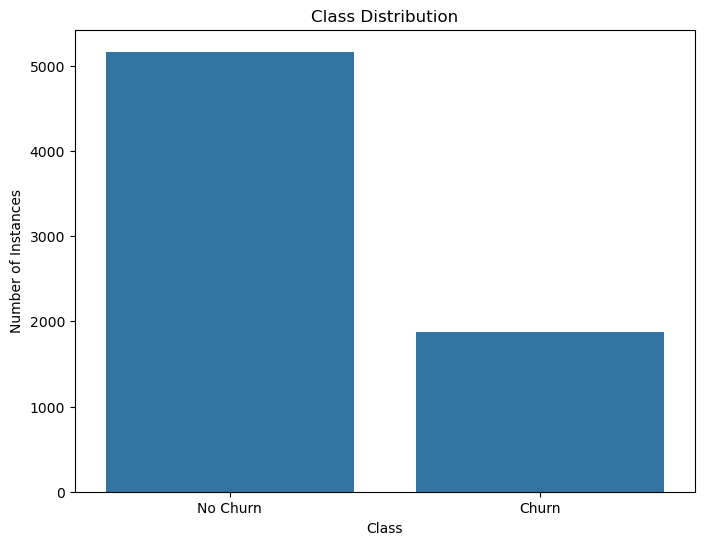

In [22]:
# Count the number of instances in each class
class_counts = dataNew['Churn'].value_counts()
print(class_counts)

# Plot the class distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Instances')
plt.xticks([0, 1], ['No Churn', 'Churn'])
plt.show()

MODEL EVALUATION

In [23]:
# scoring for cross validation
scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}

In [24]:
# helper function that prints performance from scores
def get_scores(scores):
    print(f"accuracy: {round(scores['test_accuracy'].mean(), 3)}")
    print(f"precision: {round(scores['test_precision'].mean(), 3)}")
    print(f"recall: {round(scores['test_recall'].mean(), 3)}")
    print(f"f1_score: {round(scores['test_f1_score'].mean(), 3)}")

APPLY MODEL

In [25]:
rf_classifier = RandomForestClassifier()

In [26]:
# evaluating the model
scores = cross_validate(rf_classifier, X_train, y_train, scoring=scoring, cv=10)
get_scores(scores)

accuracy: 0.797
precision: 0.65
recall: 0.511
f1_score: 0.572


METHODS OF HANDLING IMBALANCED DATA

 RandomOverSampler
 ,SMOTE
 ,Borderline-SMOTE
 ,ADASYN
 
 

In [27]:
ros = RandomOverSampler(sampling_strategy=1.0, random_state=42, shrinkage=0.2)
X_res, y_res = ros.fit_resample(X_train, y_train)

# Count the number of instances in each class
class_counts = y_res.value_counts()
print(class_counts)

print('\nEvaluate RandomOverSampler')
scores_rf = cross_validate(rf_classifier, X_res, y_res, scoring=scoring, cv=10)
get_scores(scores_rf)

Churn
0    4130
1    4130
Name: count, dtype: int64

Evaluate RandomOverSampler
accuracy: 0.844
precision: 0.859
recall: 0.814
f1_score: 0.823


In [28]:
# creating class instance
oversampler = RandomOverSampler(sampling_strategy="minority")
# fitting and resampling the data
# just like sklearn's fit_transform
oversampled_data, oversampled_target = oversampler.fit_resample(X_train, y_train)

# Count the number of instances in each class
class_counts = oversampled_target.value_counts()
print(class_counts)

print('\nEvaluate Oversampler')
scores_rf = cross_validate(rf_classifier, oversampled_data, oversampled_target, scoring=scoring, cv=10)
get_scores(scores_rf)

Churn
0    4130
1    4130
Name: count, dtype: int64

Evaluate RandomOverSampler
accuracy: 0.909
precision: 0.861
recall: 0.976
f1_score: 0.915
